In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [3]:
# Load datasets
tweets_df = pd.read_csv(r"E:\Twitter-Data-Sentimental-Analysis-main\Twitter-Data-Sentimental-Analysis-main\tweets.csv")
cleaned_tweets_df = pd.read_csv(r"E:\Twitter-Data-Sentimental-Analysis-main\Twitter-Data-Sentimental-Analysis-main\cleanedtweetsonly.csv")
tweets_only_df = pd.read_csv(r"E:\Twitter-Data-Sentimental-Analysis-main\Twitter-Data-Sentimental-Analysis-main\tweetsonly.csv")

# Display basic information
print(tweets_df.info())
print(cleaned_tweets_df.info())
print(tweets_only_df.info())

# Display first few rows of each dataset
print(tweets_df.head())
print(cleaned_tweets_df.head())
print(tweets_only_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1951 non-null   int64 
 1   created_at  1951 non-null   object
 2   text        1951 non-null   object
 3   location    1509 non-null   object
dtypes: int64(1), object(3)
memory usage: 61.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  1812 non-null   object
dtypes: object(1)
memory usage: 14.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1812 non-null   object
dtypes: object(1)
memory usage: 14.3+ KB
None
                    id           created_at  \
0  1083193473539420160  2019-01

In [4]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back to string
    return ' '.join(tokens)

# Apply preprocessing
tweets_df['cleaned_text'] = tweets_df['text'].apply(preprocess_text)


In [5]:
# Sentiment labeling using TextBlob
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return 1  # Positive
    elif sentiment == 0:
        return 0  # Neutral
    else:
        return -1  # Negative

tweets_df['sentiment'] = tweets_df['cleaned_text'].apply(get_sentiment)

# Extract day of the week and hour
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
tweets_df['day_of_week'] = tweets_df['created_at'].dt.day_name()
tweets_df['hour'] = tweets_df['created_at'].dt.hour

# Load positive and negative words
with open(r"E:\Twitter-Data-Sentimental-Analysis-main\Twitter-Data-Sentimental-Analysis-main\positive-words.txt", 'r') as file:
    positive_words = file.read().splitlines()

with open(r"E:\Twitter-Data-Sentimental-Analysis-main\Twitter-Data-Sentimental-Analysis-main\negative-words.txt", 'r') as file:
    negative_words = file.read().splitlines()

def count_words(text, words):
    return sum(1 for word in text.split() if word in words)

tweets_df['num_positive_words'] = tweets_df['cleaned_text'].apply(lambda x: count_words(x, positive_words))
tweets_df['num_negative_words'] = tweets_df['cleaned_text'].apply(lambda x: count_words(x, negative_words))


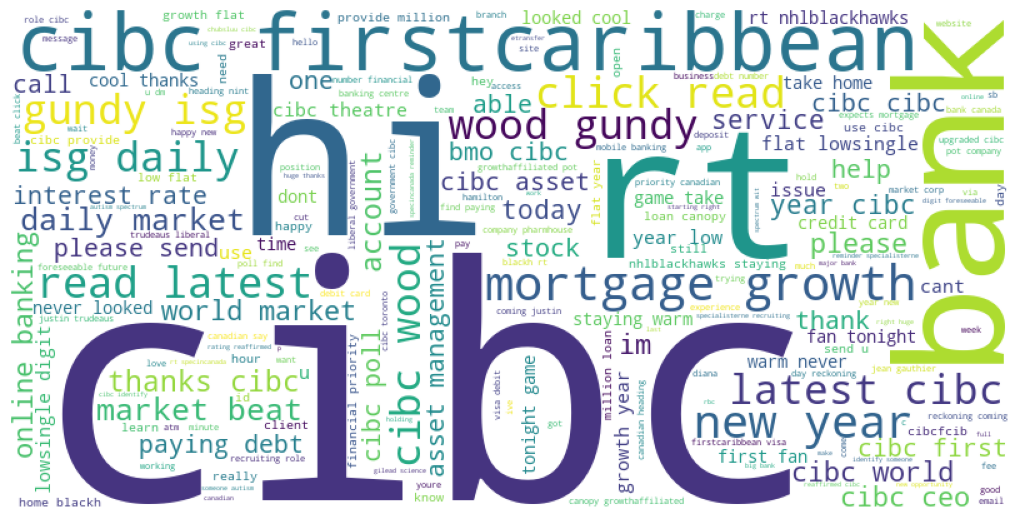

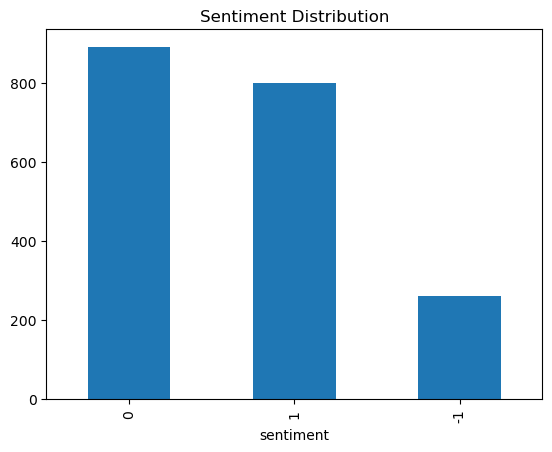

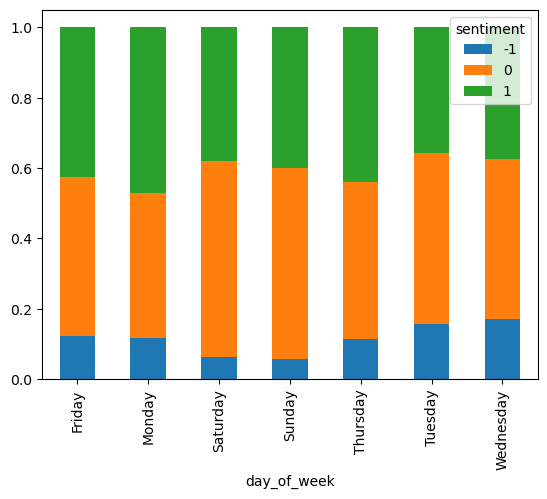

In [6]:
# Word Cloud
def plot_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(text))
    plt.figure(figsize = (10, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

plot_wordcloud(tweets_df['cleaned_text'])

# Sentiment distribution
tweets_df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

# Sentiment by Day of Week
tweets_df.groupby('day_of_week')['sentiment'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.show()


In [7]:
# Split data into features and target
X = tweets_df['cleaned_text']
y = tweets_df['sentiment']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('model', RandomForestClassifier())
])

# Handle class imbalance
ros = RandomOverSampler()

# Perform Cross Validation
param_grid = {
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5)
X_resampled, y_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)
grid_search.fit(X_resampled.flatten(), y_resampled)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the final model
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Best Parameters: {'model__max_depth': None, 'model__n_estimators': 200, 'tfidf__max_df': 0.95}
              precision    recall  f1-score   support

    Negative       0.79      0.56      0.65        54
     Neutral       0.79      0.96      0.87       181
    Positive       0.90      0.78      0.83       156

    accuracy                           0.83       391
   macro avg       0.83      0.76      0.79       391
weighted avg       0.84      0.83      0.83       391



In [8]:
# Final classifier performance
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Final Model F1 Score: {f1:.2f}")

# Feature importance
if hasattr(final_model.named_steps['model'], 'feature_importances_'):
    importances = final_model.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = final_model.named_steps['tfidf'].get_feature_names_out()
    for i in range(10):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]}")


Final Model F1 Score: 0.79
new: 0.023303031725345886
cibc: 0.022483791500275935
mortgage: 0.02192763586525121
thanks: 0.021645054440562132
growth: 0.015371745500278764
flat: 0.013168677157731281
sorry: 0.012610445944477158
year: 0.01203582876422244
bank: 0.010938494669802297
fuck: 0.008841691845918202


In [9]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Example preprocessing steps
def preprocess_text(text):
    # Lowercasing and removing punctuation (adjust as needed)
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Sample text
new_texts = ["This is a new tweet!", "Another example of text."]

# Preprocess the new texts
preprocessed_texts = [preprocess_text(text) for text in new_texts]
